### Objective: Using movies and their coresponding ratings data, try to find out:

#### 1. If one user tends to rate similar movies same or similar ratings  (Reflect his/her taste)

#### 2. Is there any positive linear relationship between number of movies a user rated and the rating he/she gave. 

##### Thus, we could recommend the similar movie that he/she hasn't rated (watched).

In [1]:
# data manipulation
import pandas as pd
# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# run model
import statsmodels.formula.api as sm
from sklearn.cluster import KMeans

Import the first dataset movies

In [3]:
movies = pd.read_csv('movies.csv')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
len(movies['genres'])

9742

In [6]:
len(movies['genres'].unique())

951

In [7]:
# because one movie could belong to multiple genres, there are too many different combination of genres. 
# Let's split genres into single word each row to facilitate data exploration.

movieId=[]
title=[]
genres =[]

for i in range(len(movies['genres'])):
    pool = movies['genres'][i].split('|')
    for j in pool:
        movieId.append(movies['movieId'][i])
        title.append(movies['title'][i])
        genres.append(j)
        
movies_df = pd.DataFrame({'movieId':movieId, 'title': title, 'genres':genres })       

In [15]:
movies_df.head()

,movieId,title,genres,genres_N
0,1,Toy Story (1995),Adventure,1
1,1,Toy Story (1995),Animation,2
2,1,Toy Story (1995),Children,3
3,1,Toy Story (1995),Comedy,4
4,1,Toy Story (1995),Fantasy,5


In [9]:
len(movies_df['genres'].unique())

20

In [10]:
movies_df['genres'].count()

22084

In [11]:
# After genres split, there are only 20 genres in total. One movie could belong to multiple genres at the same time.

In [12]:
movies_df['genres'].unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [13]:
movies_df['genres_N'] = movies_df['genres']

In [14]:
# create a dictionary for genres, replacing charactor with number for two reasons: 1. shorter 2. easier to cluster.
movies_df['genres_N'] = movies_df['genres_N'].replace({'Adventure':1, 'Animation':2, 'Children':3, 'Comedy':4, 'Fantasy':5,
       'Romance':6, 'Drama':7, 'Action':8, 'Crime':9, 'Thriller':10, 'Horror':11,
       'Mystery':12, 'Sci-Fi':13, 'War':14, 'Musical':15, 'Documentary':16, 'IMAX':17,
       'Western':18, 'Film-Noir':19, '(no genres listed)':20})

/Users/lotto/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


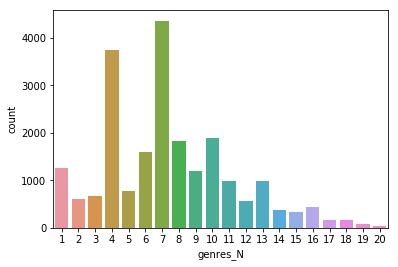

In [16]:
# Visualize the distribution of movie genres.
sns.barplot(x = 'genres_N', y = movies_df['movieId'].value_counts(), data = movies_df)
sns.countplot(x='genres_N', data=movies_df)


Drama and Comedy are the most movie genre, Thriller, Action, Romance and Adventure are the following ones.

In [17]:
movies_df.head()

,movieId,title,genres,genres_N
0,1,Toy Story (1995),Adventure,1
1,1,Toy Story (1995),Animation,2
2,1,Toy Story (1995),Children,3
3,1,Toy Story (1995),Comedy,4
4,1,Toy Story (1995),Fantasy,5


In [18]:
rel_cols=['movieId', 'genres_N']

#Determining number of clusters
nClusters=range(2,10)
sumDistances=[]
for n in nClusters:
    kmeans=KMeans(n_clusters=n).fit(movies_df[rel_cols])
    sumDistances.append(kmeans.inertia_) #Proxy for SSE

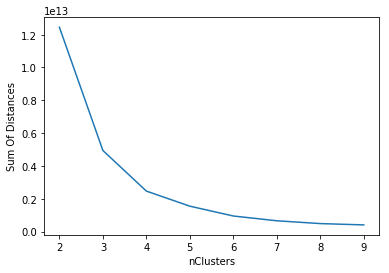

In [19]:
plt.plot(nClusters,sumDistances,'-')
plt.xlabel('nClusters')
plt.ylabel('Sum Of Distances')
plt.show()

/Users/lotto/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/lotto/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/lotto/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/lotto/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

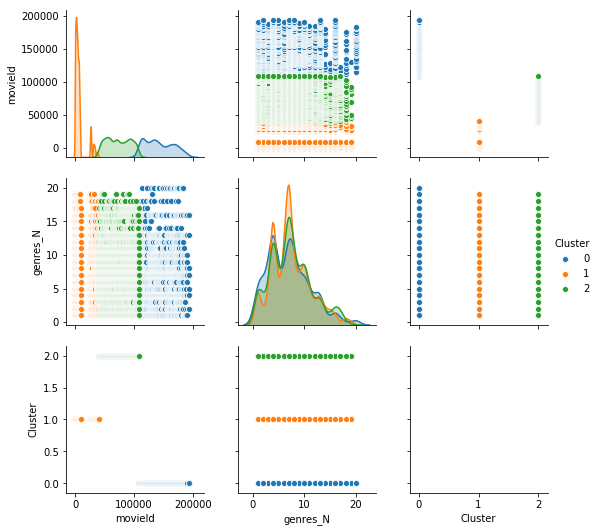

In [20]:
# From the elbow plot, seems like 3 will be the best cluster number.

kmeans=KMeans(n_clusters=3).fit(movies_df[rel_cols])
movies_df['Cluster']=kmeans.labels_
g = sns.pairplot(movies_df,hue='Cluster')

Tried clustering, didn't seem to be reasonable. It's simply use movieId to cluster. So I exported the data into SQL, and use market basket analysis similar methoid, to combine two genres to find out the most frequent conbination.

SELECT genre_1,genre_2,
COUNT(movieId) movie_COUNT FROM
( SELECT a.movieId, a.genres genre_1, b.genres genre_2, b.movieId bm
 FROM ash.Tredence a,
 ash.Tredence b
 WHERE a.movieId=b.movieId
 and a.genres <> b.genres
 and a.genres < b.genres
) Temp
GROUP BY genre_1,genre_2
order by movie_COUNT desc;

In [21]:
movies_df.to_csv('movies_df.csv',index=False)

In [22]:
movie_cluster = pd.read_csv('DataForCluster.csv')

In [23]:
movie_cluster.head()

,genre_1,genre_2,movie_COUNT
0,4,7,1013
1,6,7,934
2,4,6,884
3,7,10,831
4,8,10,653


In [24]:
rel_cols = ['genre_1','genre_2','movie_COUNT']

/Users/lotto/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/lotto/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/lotto/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/lotto/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

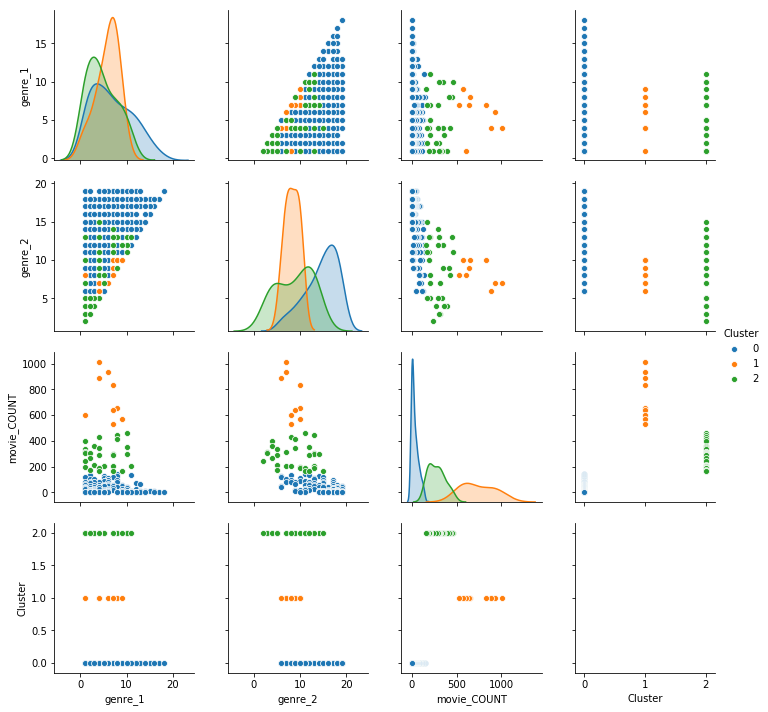

In [25]:
kmeans=KMeans(n_clusters=3).fit(movie_cluster[rel_cols])
movie_cluster['Cluster']=kmeans.labels_
g = sns.pairplot(movie_cluster,hue='Cluster')

This kind of clustering's concept is that there are movies have similar genres. Those should be clustered together. Here I just explored double combinations. Plus, after getting the cluster labels, it's complicated to get the information to the original data. This time I just follow the first cluster and proceeded. 

In [65]:
# import the second dataset ratings

In [66]:
ratings = pd.read_csv('ratings.csv')

In [67]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


/Users/lotto/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


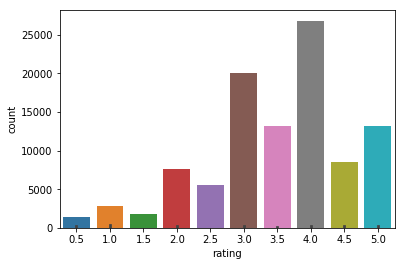

In [68]:
# Visaulize the distribution of ratings.
sns.barplot(x = 'rating', y = ratings['userId'].value_counts(), data = ratings)
sns.countplot(x='rating', data=ratings)

/Users/lotto/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


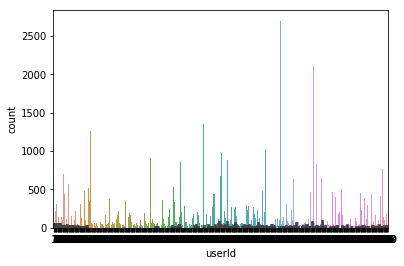

In [69]:
sns.barplot(x = 'userId', y = ratings['movieId'].value_counts(), data = ratings)
sns.countplot(x='userId', data=ratings)

In [70]:
len(ratings['userId'].unique())

610

In [71]:
len( ratings['movieId'].unique())

9724

In [72]:
# There are 610 users gave their ratings, 9724 out of 9742 movies are rated.

In [76]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [73]:
# calculate # of reviews group by zipcode and year. That is, to see the popularity of each region each year.
f = {'movieId':['count']}

# create a new dataframe:yelp_count to keep the aggregated data.
rating_count = ratings.groupby(['userId'], sort = True, as_index = False).agg(f)

In [74]:
list(rating_count.columns)

[('userId', ''), ('movieId', 'count')]

In [75]:
# find the user who rated most movies. Use this user as a samole.
rating_count[rating_count[('movieId', 'count')]== rating_count[('movieId', 'count')].max()]

,userId,movieId
,,count
413,414,2698


In [77]:
# To get more information, let's join splited-gnere moives and ratings to get idea of which genre get the highest rateings.

In [78]:
movies_ratings = ratings.merge(movies_df, left_on='movieId', right_on='movieId')

In [79]:
movies_ratings.head()

,userId,movieId,rating,timestamp,title,genres,genres_N,Cluster
0,1,1,4.0,964982703,Toy Story (1995),Adventure,1,1
1,1,1,4.0,964982703,Toy Story (1995),Animation,2,1
2,1,1,4.0,964982703,Toy Story (1995),Children,3,1
3,1,1,4.0,964982703,Toy Story (1995),Comedy,4,1
4,1,1,4.0,964982703,Toy Story (1995),Fantasy,5,1


In [80]:
# Subset the user saw the most movie.
user414_rating = movies_ratings[movies_ratings['userId']==414]

In [62]:
# To compare the ratings in different cluster, I changed Cluster to string.
user414_rating['Cluster'] = user414_rating['Cluster'].astype(str)

/Users/lotto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
LR1 = sm.ols(formula="rating ~ Cluster", data=user414_rating).fit() 
#Running the linear regression of ratings on Clusters
print(LR1.summary()) #Printing the summary results

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     72.99
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           4.43e-32
Time:                        00:06:04   Log-Likelihood:                -8841.3
No. Observations:                6616   AIC:                         1.769e+04
Df Residuals:                    6613   BIC:                         1.771e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.0594      0.059     68.854   

### Yes, this user did give different cluster significantly different ratings, according to the p value of cluster 1,2 as oppose to Cluster 0. Cluster 1 and cluster 2 have lower ratings comparing to cluster 0.

In [64]:
LR2 = sm.ols(formula="rating ~ genres", data=user414_rating).fit() 
#Running the linear regression of ratings on Clusters
print(LR2.summary()) #Printing the summary results

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     9.102
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           1.86e-26
Time:                        00:06:22   Log-Likelihood:                -8827.9
No. Observations:                6616   AIC:                         1.770e+04
Df Residuals:                    6596   BIC:                         1.783e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.25

In [ ]:
# Run another regression to prove that, there is no significant rating difference between genres.

Let's move on to the second hypothesis: the more same genre one user watched, the higher the average rating he/she will give.

In [85]:
# calculate count of ratings group by userId and genres. That is, to see the ratings count of each user each genre.
f = {'movieId':['count']}

# create a new dataframe: userated_count to keep the aggregated data.
userated_count = movies_ratings.groupby(['userId','genres'], sort = False, as_index = False).agg(f)

In [86]:
userated_count.head()

,userId,genres,movieId
,,,count
0,1,Adventure,85
1,1,Animation,29
2,1,Children,42
3,1,Comedy,83
4,1,Fantasy,47


In [87]:
# calculate average mean group by userId and genres. That is, to see the average ratings of each user each genre.
f = {'rating':['mean']}

# create a new dataframe: userating_mean to keep the aggregated data.
userating_mean = movies_ratings.groupby(['userId','genres'], sort = False, as_index = False).agg(f)

In [88]:
userating_mean.head()

,userId,genres,rating
,,,mean
0,1,Adventure,4.388235
1,1,Animation,4.689655
2,1,Children,4.547619
3,1,Comedy,4.277108
4,1,Fantasy,4.297872


In [89]:
# Merge them to build model
user_rating = userated_count.merge(userating_mean, left_on=[('userId', ''),('genres', '')], right_on=[('userId', ''),('genres', '')], how= 'inner')

In [93]:
user_rating.head()

,userId,genres,movieId,rating
,,,count,mean
0,1,Adventure,85,4.388235
1,1,Animation,29,4.689655
2,1,Children,42,4.547619
3,1,Comedy,83,4.277108
4,1,Fantasy,47,4.297872


In [91]:
list(user_rating.columns)

[('userId', ''), ('genres', ''), ('movieId', 'count'), ('rating', 'mean')]

In [92]:
# rename the new column to clean, easy to understand name.
user_rating.rename(columns={('movieId', 'count'):'count'}, inplace=True)

Take care of the column name. 

In [97]:
user_rating.to_csv('user_rating.csv',index=False)

In [100]:
user_rating = pd.read_csv('user_rating.csv')

In [101]:
LinearRreg = sm.ols(formula="mean ~ count", data=user_rating).fit() 
#Running the linear regression of average rating on count
print(LinearRreg.summary()) #Printing the summary results

                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     71.76
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           2.77e-17
Time:                        00:38:23   Log-Likelihood:                -10694.
No. Observations:               10027   AIC:                         2.139e+04
Df Residuals:                   10025   BIC:                         2.141e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6740      0.008    475.071      0.0

### Opposite to I assumed, turns out the more same genre movie a user watched, the lower average of rating he/she will give. Since the coef of count is negative, means if 1 more movie is watched, the average rating will decrease 0.001.